# Rapsodo Stuff+

A Stuff+ model that is trained on data available to rapsodo users

***Author***: Jensen Holm <br>
***Date***: 12/20/2024 <br>

In [3]:
import statcast_pitches
import polars as pl
from plotnine import *

**Dataset**

all pitches thrown in the 2024 MLB season will be used. It is important to drop missing data for the features that we are interested in.

Rapsodo provides release speed, release extension, release spin rate, horizontal movement, and vertical movement. These will be used as features initially in this model before feature selection. 

In [2]:
all_features = [
    "release_speed",
    "release_extension",
    "release_spin_rate",
    "pfx_x",
    "pfx_z",
    "pitch_type",
]

statcast_24_df = (statcast_pitches.load()
                    .filter(pl.col("game_date").dt.year() == 2024)
                    .drop_nulls(subset=all_features))

(statcast_24_df
    .select(all_features)
    .describe())

statistic,release_speed,release_extension,release_spin_rate,pfx_x,pfx_z,pitch_type
str,f64,f64,f64,f64,f64,str
"""count""",739346.0,739346.0,739346.0,739346.0,739346.0,"""739346"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",89.167052,6.454948,2255.967013,-0.100391,0.589012,null
"""std""",5.973283,0.457133,361.833614,0.897559,0.70556,null
"""min""",31.9,3.2,9.0,-2.95,-1.98,"""CH"""
"""25%""",84.9,6.2,2103.0,-0.87,0.13,null
"""50%""",90.0,6.5,2288.0,-0.16,0.63,null
"""75%""",94.0,6.7,2465.0,0.62,1.2,null
"""max""",105.5,8.7,3578.0,2.4,2.31,"""SV"""


## Feature Engineering

collection of functions that each do one thing to the data that hopefully leads to model performance improvements

The first thing that I have to do in order to make the model 'handedness agnostic', is to mirror the physical characteristics of balls thrown by LHP, as if they were thrown by RHP. 

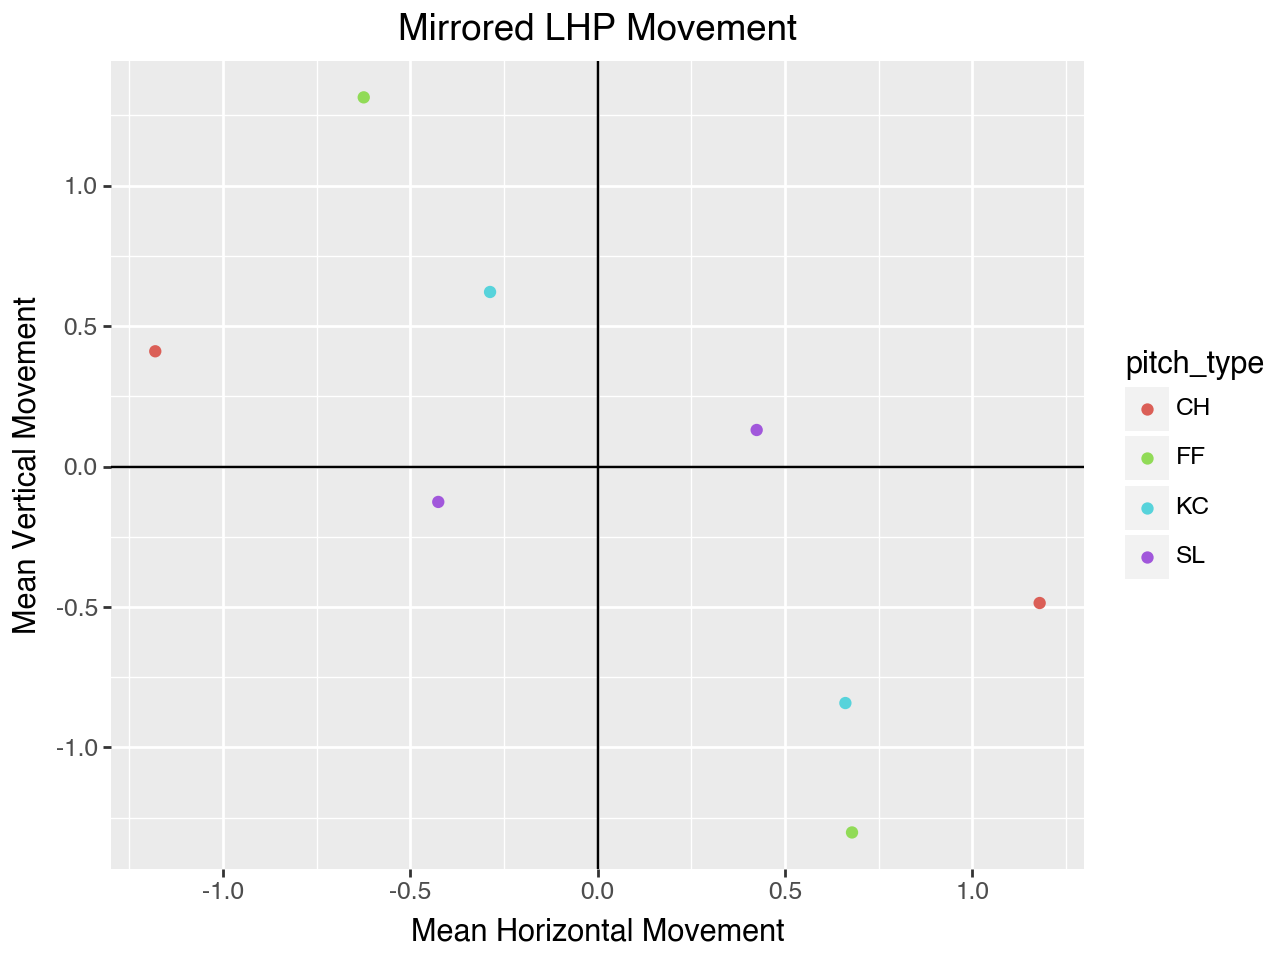

In [7]:

def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    # flip horizontal break
    return lf.with_columns(
        pl.when(pl.col("p_throws") == "L")
        .then((-pl.col("pfx_z")))
        .otherwise(pl.col("pfx_z"))
    )

mirrored_statcast_24_df = statcast_24_df.pipe(mirror_lhp_to_rhp)

# make sure that it worked
mirror_plt = (
    ggplot(
        (mirrored_statcast_24_df
            .filter(pl.col("pitch_type").is_in(["FF", "SL", "CH", "KC", "CT"]))
            .group_by("pitch_type", "p_throws"))
            .agg(
                pl.col("pfx_x").mean().alias("mean_pfx_x"),
                pl.col("pfx_z").mean().alias("mean_pfx_z"),
            )
            .collect(),
        aes(x="mean_pfx_x", y="mean_pfx_z", color="pitch_type")
    )
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement",
        x="Mean Horizontal Movement",
        y="Mean Vertical Movement",
    )
)

mirror_plt.show()